In [ ]:
# This notebook has been run on Google Colab. To run it, uncomment the following lines

# !rm -r Few-shot-learning-with-HuBERT
# !git clone -b timit --single-branch \
# https://github.com/luckyman94/Few-shot-learning-with-HuBERT.git

# !pip install -U kagglehub

# !rm -r kagglehub_cache/


rm: cannot remove 'Few-shot-learning-with-HuBERT': No such file or directory
Cloning into 'Few-shot-learning-with-HuBERT'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 187 (delta 72), reused 164 (delta 49), pack-reused 0 (from 0)
Receiving objects: 100% (187/187), 1.90 MiB | 34.78 MiB/s, done.
Resolving deltas: 100% (72/72), done.
rm: cannot remove 'kagglehub_cache/': No such file or directory


In [ ]:

import os
import sys
from pathlib import Path
import torch
from collections import Counter
from tqdm import tqdm

# ---- Hugging Face token ----
# Uncomment the following line if you want to run the notebook on Google Colab. Make sure to replace "YOUR
#os.environ["HF_TOKEN"] = "YOUR TOKEN HERE"

# Uncomment the following lines if you want to run the notebook on Google Colab
#ROOT = Path.cwd() / "Few-shot-learning-with-HuBERT"
#sys.path.append(str(ROOT))

assert "HF_TOKEN" in os.environ
project_root = Path().resolve().parent
sys.path.append(str(project_root))


# ---- Project imports ----
from transformers import HubertModel

from src.datasets.timit import TimitDataset
from src.methods.fewshot.benchmark import benchmark_fewshot
from src.evaluation.evaluate import evaluate_benchmark
from src.methods.fewshot.sampling import sample_task
from src.methods.fewshot.prototypical import compute_prototypes, classify

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Example : 1 experiment

In [3]:
dataset = TimitDataset(
    root_dir="data/TRAIN",
    n_speakers=10,
    max_files=1000,
)

print("Classes:", dataset.classes)
print("Nb samples:", len(dataset))

x, y = dataset[0]
print(x.shape, y)


100%|██████████| 829M/829M [00:37<00:00, 23.4MB/s]

Extracting files...


[INFO] Total speakers in TIMIT: 462
[INFO] TIMIT Dataset loaded: 200 files | 10 speakers
Classes: ['MMJB1', 'FJWB1', 'FCAG0', 'MRLJ0', 'MAEO0', 'FSPM0', 'FSJG0', 'FLEH0', 'MRKM0', 'FJLR0']
Nb samples: 200
torch.Size([16000]) 5


In [4]:
labels = [dataset[i][1] for i in range(len(dataset))]
print(Counter(labels))


Counter({5: 20, 4: 20, 7: 20, 8: 20, 6: 20, 1: 20, 2: 20, 9: 20, 0: 20, 3: 20})


In [5]:
X = []
y = []

for waveform, label in tqdm(dataset, desc="Loading dataset"):
    X.append(waveform)
    y.append(label)

X = torch.stack(X)
y = torch.tensor(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


Loading dataset: 100%|██████████| 200/200 [00:01<00:00, 140.81it/s]

X shape: torch.Size([200, 16000])
y shape: torch.Size([200])


In [6]:
X_support, y_support, X_query, y_query = sample_task(
    X,
    y,
    n_way=10,
    k_shot=1,
    n_query=20
)


In [7]:
hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960", use_safetensors=True)
hubert.eval().to(device)

for p in hubert.parameters():
    p.requires_grad = False

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

In [8]:
prototypes, proto_labels = compute_prototypes(
    hubert, X_support, y_support, device=device
)

preds = classify(
    hubert, X_query, prototypes, proto_labels, device=device
)

acc = (preds.cpu() == y_query).float().mean()
print("Few-shot accuracy:", acc.item())


Few-shot accuracy: 0.27368420362472534


## Benchmark

In [11]:
results = {}
for k in [1,5,10]:
    results[k] = benchmark_fewshot(model=hubert, X=X, y=y, device=device, k_shot=k, n_tasks=100)


10-shot benchmark: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]



===== Few-shot evaluation summary =====

--- 1-shot ---
Accuracy : 0.4402 ± 0.0989
F1 macro : 0.4315


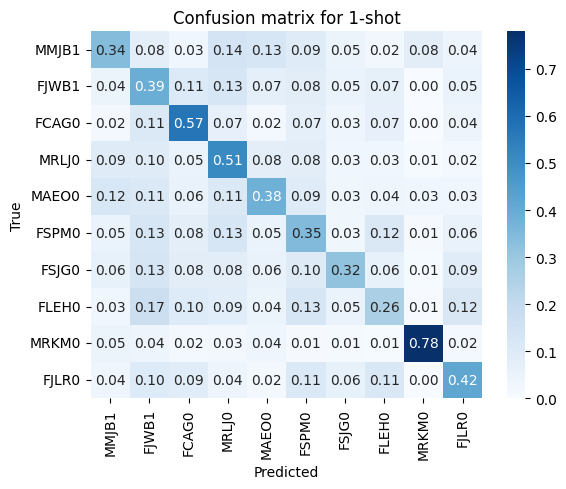


=== Evaluation metrics ===
accuracy    : 0.4402
f1_macro    : 0.4315
precision_macro: 0.4397
recall_macro: 0.4320


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


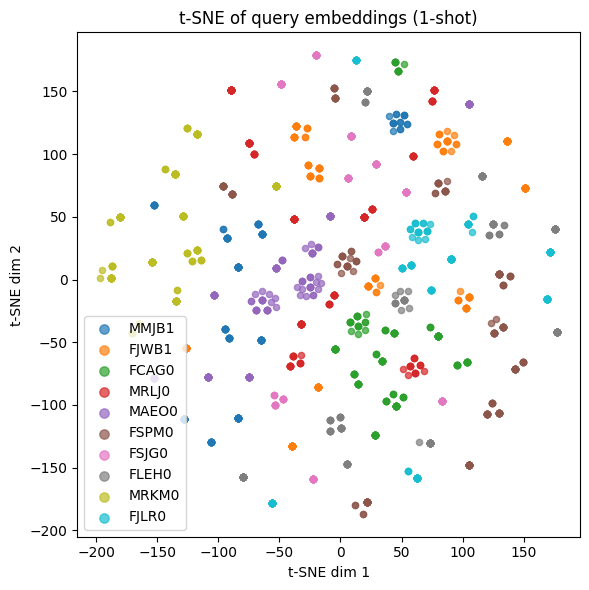


--- 5-shot ---
Accuracy : 0.6239 ± 0.0789
F1 macro : 0.6284


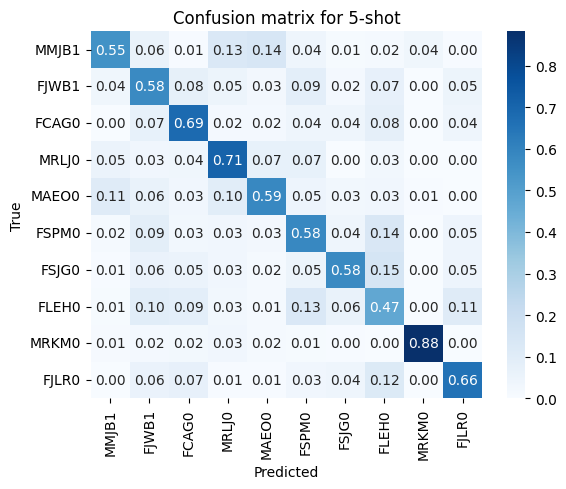


=== Evaluation metrics ===
accuracy    : 0.6239
f1_macro    : 0.6284
precision_macro: 0.6348
recall_macro: 0.6273


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


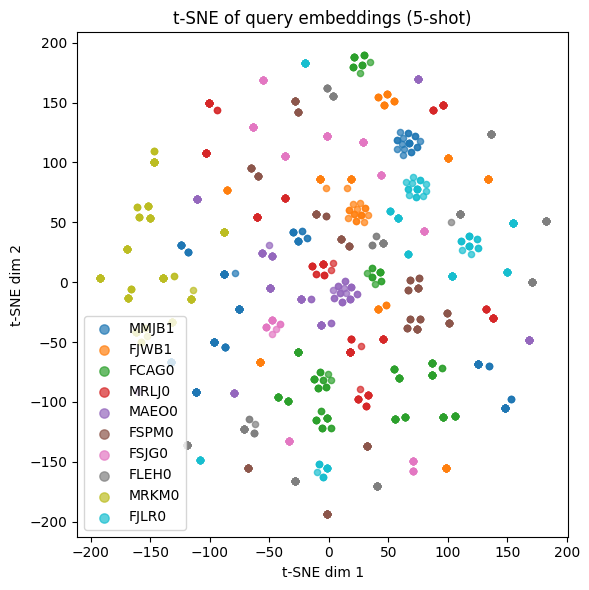


--- 10-shot ---
Accuracy : 0.7308 ± 0.0875
F1 macro : 0.7325


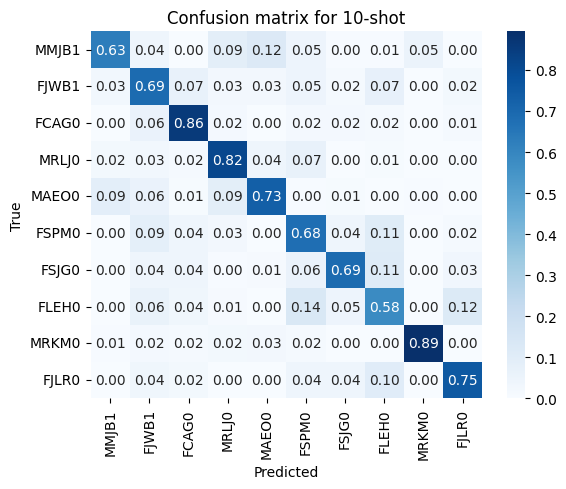


=== Evaluation metrics ===
accuracy    : 0.7308
f1_macro    : 0.7325
precision_macro: 0.7379
recall_macro: 0.7324


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


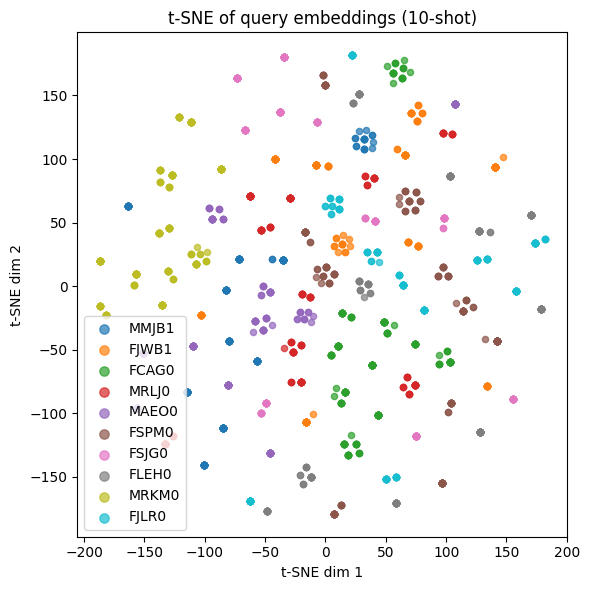

In [12]:
evaluate_benchmark(results, class_names=dataset.classes)